# pyLemur Walkthrough

Constantin Ahlmann-Eltze  
2024-03-19

The goal of `pyLemur` is to simplify analysis of multi-condition
single-cell data. If you have collected a single-cell RNA-seq dataset
with more than one condition, lemur predicts for each cell and gene how
much the expression would change if the cell had been in the other
condition.

`pyLemur` is a Python implementation of the LEMUR model; there is also
an `R` package called [lemur](https://bioconductor.org/packages/lemur/)
which provides additional functionality: identifying neighborhoods of
cells that show consistent differential expression values and a
pseudo-bulk test to validate the findings.

`pyLemur` implements a novel framework to disentangle the effects of
known covariates, latent cell states, and their interactions. At the
core, is a combination of matrix factorization and regression analysis
implemented as geodesic regression on Grassmann manifolds. We call this
latent embedding multivariate regression. For more details see our
[preprint](https://www.biorxiv.org/content/10.1101/2023.03.06.531268).

<img src="../_static/images/equation_schematic.png" alt="Schematic of the matrix decomposition atthe core of LEMUR" />

## Data

For demonstration, I will use the a dataset of interferon-$\beta$
stimuted blood cells from Kang et al. (2018).

In [1]:
# Standard imports
import numpy as np
import scanpy as sc
# pertpy is need to download the kang data
import pertpy 

# This will download the data to ./data/kang_2018.h5ad
adata = pertpy.data.kang_2018()
# Store counts separately in the layers
adata.layers["counts"] = adata.X.copy()

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

The data consist of $24\,673$ cells and $15\,706$ genes. The cells were
measured in two conditions (`label="ctrl"` and `label="stim"`). The
authors have annotated the cell type for each cell. This will be useful
to analyze LEMUR’s results, but the cell type labels are not actually
used to the LEMUR model.

In [3]:
print(adata)
print(adata.obs)

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'
                  nCount_RNA  nFeature_RNA      tsne1      tsne2 label  cluster        cell_type     replicate  nCount_SCT  nFeature_SCT integrated_snn_res.0.4 seurat_clusters
index                                                                                                                                                                          
AAACATACATTTCC-1      3017.0           877 -27.640373  14.966629  ctrl        9  CD14+ Monocytes  patient_1016      1704.0           711                    1                 1
AAACATACCAGAAA-1      2481.0           713 -27.493646  28.924885  ctrl        9  CD14+ Monocytes  patient_1256      1614.0           662                    1                 1
AAA

## Preprocessing

LEMUR expects that the input has been variance-stabilized. Here, I will
use the log-transformation as a simple, yet effective approach. In
addition, I will select the $1\,000$ most variable genes, to make the
results easier to manage.

In [4]:
# This follows the standard recommendation from scanpy 
sc.pp.normalize_total(adata, target_sum = 1e4, inplace=True)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 24673 × 1000
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'logcounts'

If we make a dimensional-embedding of the data using UMAP, we see that
the cell types split-up by treatment status.

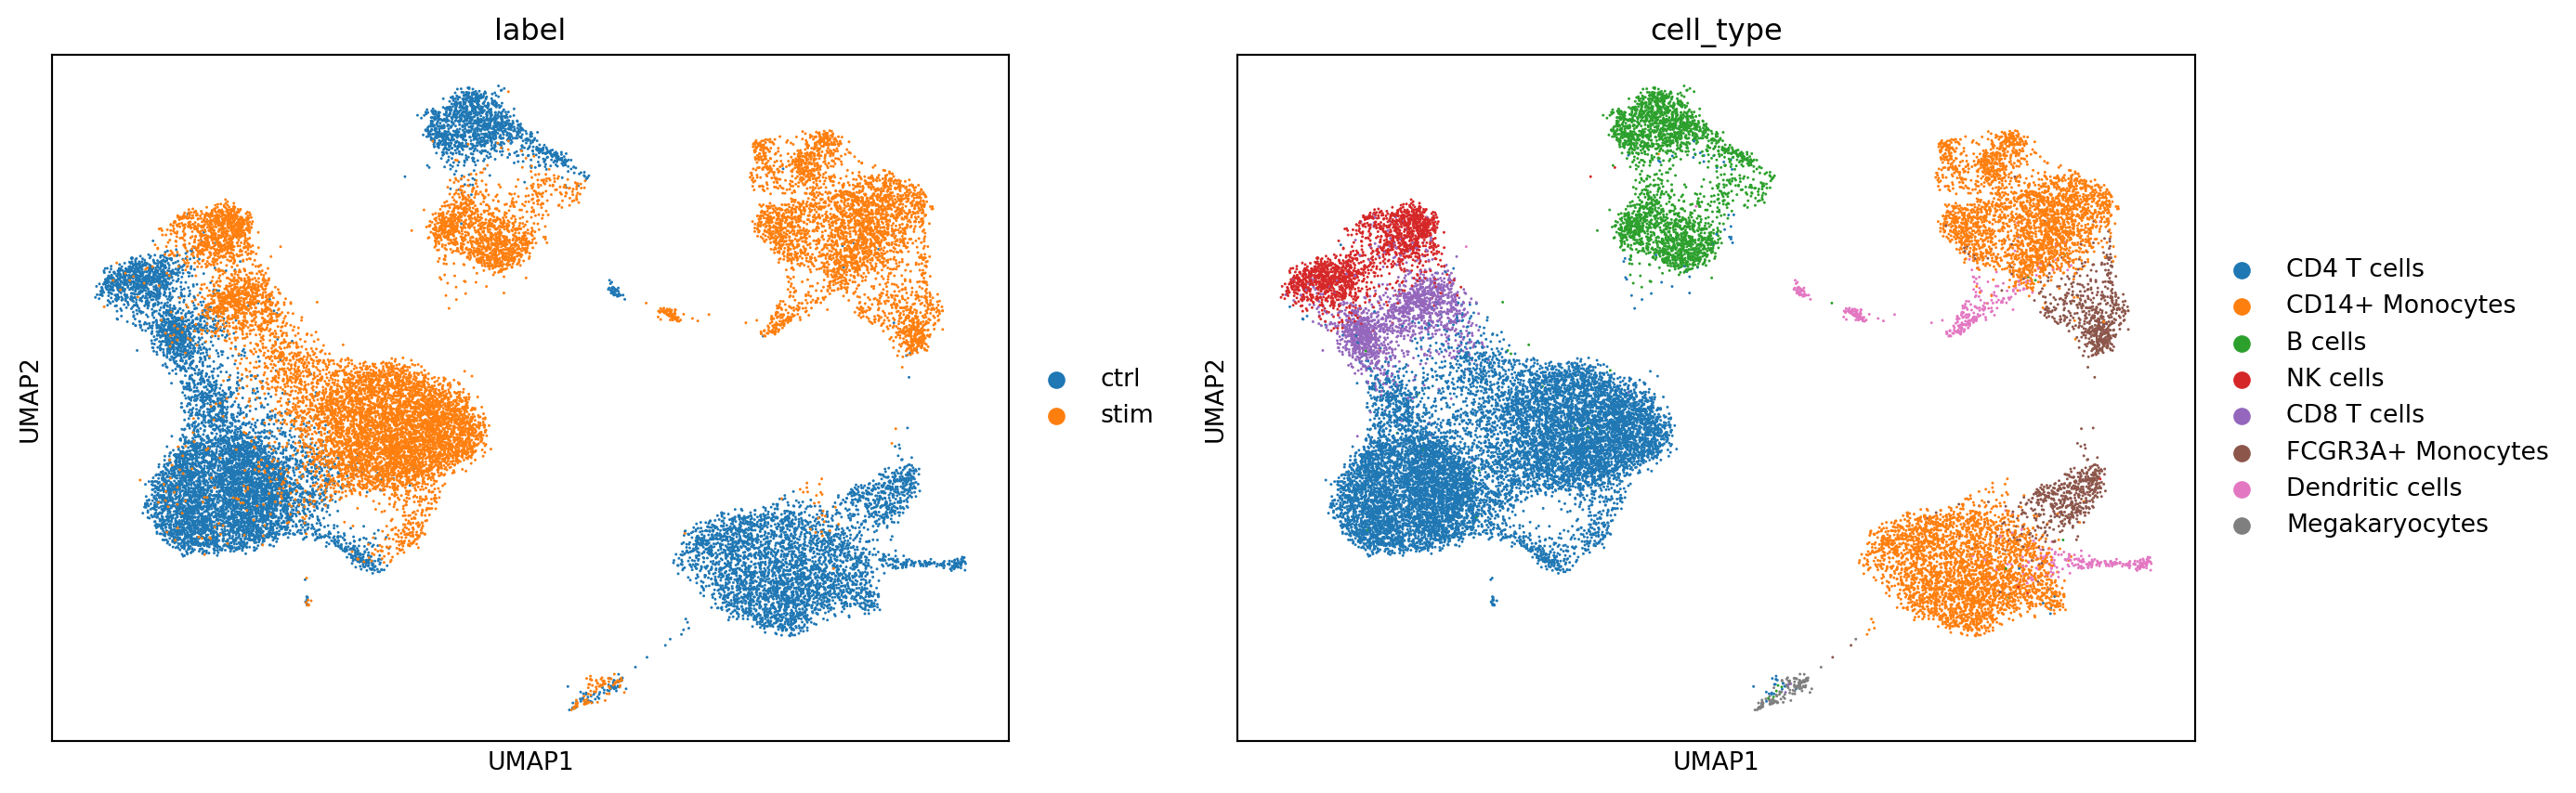

In [5]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["label", "cell_type"])

## LEMUR

First, we import `pyLemur`; then, we fit the LEMUR model by providing
the `AnnData` object, a specification of the experimental design, and
the number of latent dimensions.

In [6]:
import pylemur
fit = pylemur.tl.lemur(adata, design = "~ label", n_embedding=15)
fit = pylemur.tl.align_with_harmony(fit)

Centering the data using linear regression.
Find base point
Fit regression on latent spaces
Find shared embedding coordinates
Iteration 0
Alignment error: 73.13359924403092
Iteration 1
Alignment error: 81.16769722639704
Iteration 2
Alignment error: 81.68685854934333
Iteration 3
Alignment error: 81.72938640118974
Iteration 4
Alignment error: 81.76270137564892
Iteration 5
Alignment error: 81.77369338504862
Converged

2024-03-19 14:40:51,198 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-19 14:40:53,173 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-19 14:40:53,347 - harmonypy - INFO - Stopped before convergence

To assess the success of the LEMUR model fit, we plot a UMAP
representation of the embedding calculated by LEMUR. Here, the two
conditions are mixed and the different cell types and cell states drive
the visible variation.

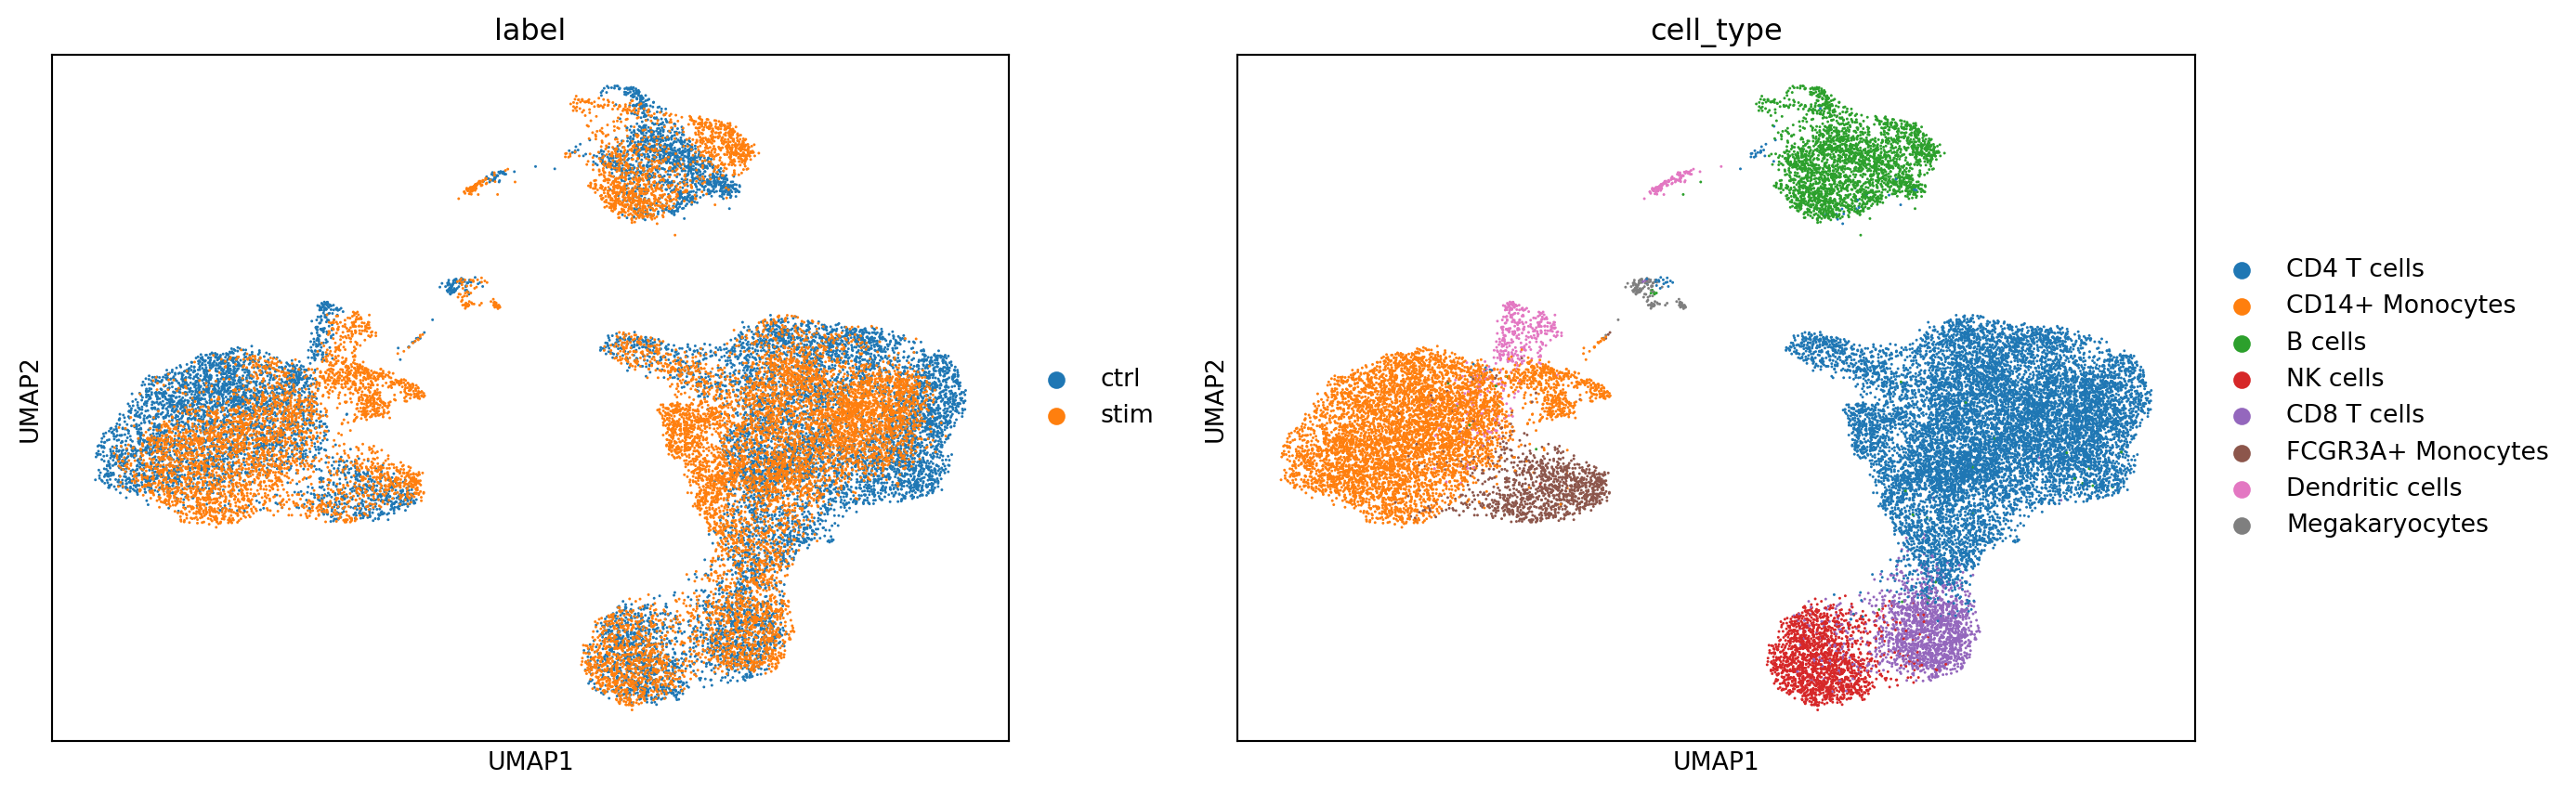

In [7]:
# Recalculate the UMAP embedding on calculated by LEMUR
sc.pp.neighbors(fit, use_rep="embedding")
sc.tl.umap(fit)
sc.pl.umap(fit, color=["label", "cell_type"])

The LEMUR model is fully parametric, which means that we can predict for
each cell what it’s expression would have been in any condition (i.e.,
for a cell observed in the control condition, we can predict its
expression under treatment), as a function of its low-dimensional
embedding.

In [8]:
ctrl_pred = pylemur.tl.predict(fit, new_condition=pylemur.tl.cond(fit, label="ctrl"))
stim_pred = pylemur.tl.predict(fit, new_condition=pylemur.tl.cond(fit, label="stim"))

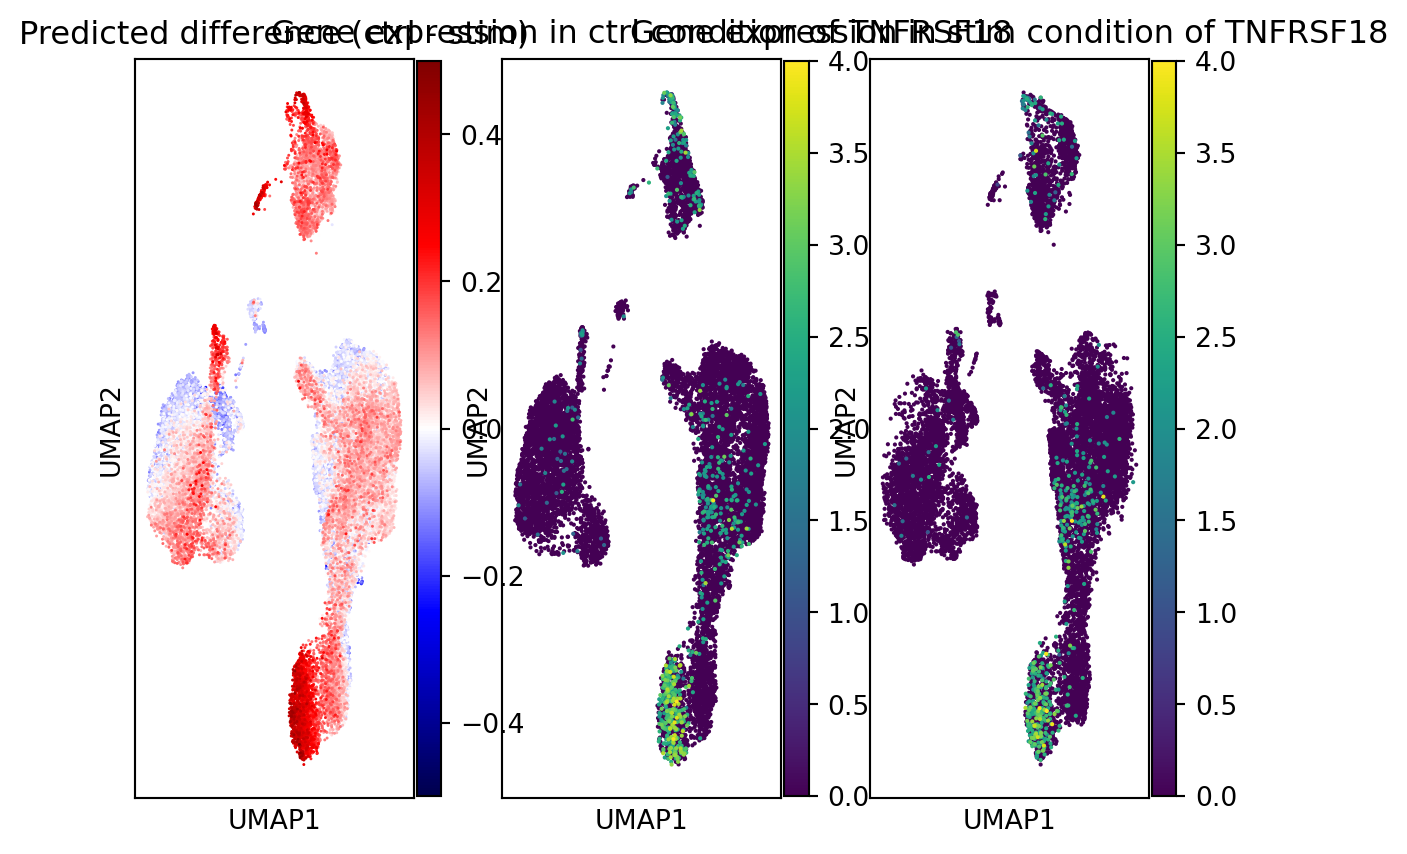

In [9]:
import matplotlib.pyplot as plt
fit.layers["diff"] = ctrl_pred - stim_pred
sel_gene = "TNFRSF18"

_,axs = plt.subplots(nrows = 1, ncols = 3)
sc.pl.umap(fit, layer="diff", color=[sel_gene], cmap = plt.get_cmap("seismic"), vcenter=0,
    vmin = -0.5, vmax =0.5, title="Predicted difference (ctrl - stim)", ax=axs[0], show=False)
sc.pl.umap(fit[fit.obs["label"]=="ctrl"], layer="logcounts", color=[sel_gene], vmin = 0, vmax =4,
    title="Gene expression in ctrl condition of " + sel_gene, ax=axs[1], show=False)
sc.pl.umap(fit[fit.obs["label"]=="stim"], layer="logcounts", color=[sel_gene], vmin = 0, vmax =4,
    title="Gene expression in stim condition of " + sel_gene, ax=axs[2])

### Session Info

In [10]:
import session_info
# session_info.show()

### References

Kang, Hyun Min, Meena Subramaniam, Sasha Targ, Michelle Nguyen, Lenka
Maliskova, Elizabeth McCarthy, Eunice Wan, et al. 2018. “Multiplexed
Droplet Single-Cell RNA-Sequencing Using Natural Genetic Variation.”
*Nature Biotechnology* 36 (1): 89–94.
<https://doi.org/10.1038/nbt.4042>.